#Proyecto Final

Pablo Ebohon Serna, 100545917

Emilio Muñoz ALvarez, 100429831

Proyecto basado en 20.130 muestras en un fichero JSON, las cuales tienen varias características, entre las que hay unas de formato número (como lo que hemos visto hasta ahora), y también formato texto. Estas características en formato texto necesitarán que se implemente un pipeline (usar librerías como NLTK, Gensim o SpaCy etc...)
Para comenzar leemos el fichero JSON que vamos a utilizar:

In [6]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.svm import NuSVC
from sklearn.metrics import confusion_matrix
import scipy.io       # To read matlab files
from scipy import spatial
import pylab
import pandas as pd
from io import StringIO
import json
#------------------------------------------------

df = pd.read_json('full_format_recipes.json') # Se le el json y se convierte en un Data Frame de Pandas
column_names = df.columns # Accede a los nombres de las columnas del Data Frame
print(column_names)
df.head() # Muestra las primeras 5 filas

Index(['directions', 'fat', 'date', 'categories', 'calories', 'desc',
       'protein', 'rating', 'title', 'ingredients', 'sodium'],
      dtype='object')


,directions,fat,date,categories,calories,desc,protein,rating,title,ingredients,sodium
0,"[1. Place the stock, lentils, celery, carrot, ...",7.0,2006-09-01 04:00:00+00:00,"[Sandwich, Bean, Fruit, Tomato, turkey, Vegeta...",426.0,None,30.0,2.500,"Lentil, Apple, and Turkey Wrap","[4 cups low-sodium vegetable or chicken stock,...",559.0
1,[Combine first 9 ingredients in heavy medium s...,23.0,2004-08-20 04:00:00+00:00,"[Food Processor, Onion, Pork, Bake, Bastille D...",403.0,This uses the same ingredients found in boudin...,18.0,4.375,Boudin Blanc Terrine with Red Onion Confit,"[1 1/2 cups whipping cream, 2 medium onions, c...",1439.0
2,[In a large heavy saucepan cook diced fennel a...,7.0,2004-08-20 04:00:00+00:00,"[Soup/Stew, Dairy, Potato, Vegetable, Fennel, ...",165.0,None,6.0,3.750,Potato and Fennel Soup Hodge,"[1 fennel bulb (sometimes called anise), stalk...",165.0
3,[Heat oil in heavy large skillet over medium-h...,NaN,2009-03-27 04:00:00+00:00,"[Fish, Olive, Tomato, Sauté, Low Fat, Low Cal,...",NaN,The Sicilian-style tomato sauce has tons of Me...,NaN,5.000,Mahi-Mahi in Tomato Olive Sauce,"[2 tablespoons extra-virgin olive oil, 1 cup c...",NaN
4,[Preheat oven to 350°F. Lightly grease 8x8x2-i...,32.0,2004-08-20 04:00:00+00:00,"[Cheese, Dairy, Pasta, Vegetable, Side, Bake, ...",547.0,None,20.0,3.125,Spinach Noodle Casserole,"[1 12-ounce package frozen spinach soufflé, th...",452.0


In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#3. PROYECTO BÁSICO

##3.1. Relación/análisis variables entrada en categories con la de salida rating.

"Ver la relación que tienen las distintas categorías (en total son 645, pero no hace falta todas, ver unas cuantas) con el rating que presentan."

In [8]:
# Asegúrate de que la columna 'categories' está limpia y es utilizable
df_exploded = df.explode('categories')  # Si 'categories' es una lista


# Agrupa por categoría y calcula la media del rating
rating_by_category = df_exploded.groupby('categories')['rating'].mean().sort_values(ascending=False)
# Se muestran las 10 categorías con mayor puntuación promedio
print(rating_by_category.head(10))

# Se extraen todas las categorias del Data Frame y las ordena por orden de frecuencia
print(df_exploded['categories'].value_counts())

# Se escogen las categorías más frecuentes y se hace la media de sus ratings
top_categories = df_exploded['categories'].value_counts().head(5).index.tolist()
print("Top 5 categorías más frecuentes:", top_categories)

# Filtrar las filas que corresponden a las categorías seleccionadas
filtered_df = df_exploded[df_exploded['categories'].isin(top_categories)]

# Calcular la media de rating para cada una de las 5 categorías más frecuentes
mean_ratings = filtered_df.groupby('categories')['rating'].mean()

print("Media de ratings para las categorías más frecuentes:")
print(mean_ratings)



categories
Sourdough            5.0000
Suzanne Goin         5.0000
#WasteLess           5.0000
Yonkers              5.0000
Las Vegas            5.0000
Mortar and Pestle    5.0000
Burrito              5.0000
Rub                  5.0000
Emeril Lagasse       5.0000
Omelet               4.6875
Name: rating, dtype: float64
categories
Bon Appétit        9355
Peanut Free        8390
Soy Free           8088
Tree Nut Free      7044
Vegetarian         6846
                   ... 
Sorbet                1
Dorie Greenspan       1
Camping               1
New Hampshire         1
Sourdough             1
Name: count, Length: 674, dtype: int64
Top 5 categorías más frecuentes: ['Bon Appétit', 'Peanut Free', 'Soy Free', 'Tree Nut Free', 'Vegetarian']
Media de ratings para las categorías más frecuentes:
categories
Bon Appétit      3.893038
Peanut Free      3.866359
Soy Free         3.866067
Tree Nut Free    3.862685
Vegetarian       3.776110
Name: rating, dtype: float64


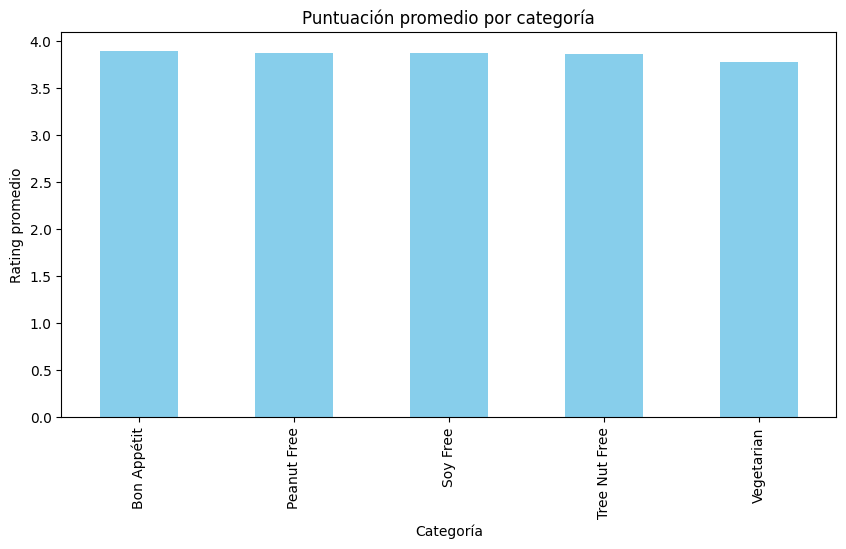

In [9]:
# Graficar las categorías más importantes con sus ratings promedio
mean_ratings.plot(kind='bar', figsize=(10, 5), color='skyblue')

plt.title('Puntuación promedio por categoría')
plt.xlabel('Categoría')
plt.ylabel('Rating promedio')
plt.show()

##3.2. Implementación de un pipeline para el preprocesado de los textos

In [11]:
#Preprocesamiento
!pip install nltk spacy
!python -m spacy download en_core_web_sm
!python -m spacy download es_core_news_sm
!pip install gensim
!pip install nltk
import nltk
import nltk
import spacy
import string
from nltk.corpus import stopwords
from spacy import displacy
from gensim import corpora
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
nlp = spacy.load('en_core_web_sm')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt_tab')

  Using cached numpy-2.3.0-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (62 kB)
Using cached numpy-2.3.0-cp311-cp311-manylinux_2_28_x86_64.whl (16.9 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scipy 1.13.1 requires numpy<2.3,>=1.22.4, but you have numpy 2.3.0 which is incompatible.
gensim 4.3.3 requires numpy<2.0,>=1.18.5, but you have numpy 2.3.0 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.3.0 which is incompatible.
cupy-cuda12x 13.3.0 requires numpy<2.3,>=1.22, but you have numpy 2.3.0 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.3.0 which is incompatible.
tsfresh 0.21.0 requires scipy>=1.14.0; python_version >= "3

/usr/local/lib/python3.11/dist-packages/cupyx/scipy/sparse/_base.py:10: UserWarning: A NumPy version >=1.22.4 and <2.3.0 is required for this version of SciPy (detected version 2.3.0)
  import scipy.sparse as _sparse
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 53.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
/usr/local/lib/python3.11/dist-packages/cupyx/scipy/sparse/_base.py:10: UserWarning: A NumPy version >=1.22.4 and <2.3.0 is required for this version of SciPy (detected version 2.3.0)
  import scipy.sparse as _sparse
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 71.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package 

ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

## Se preprocesa el texto

In [12]:
def preprocess_text(text):
    # Tokenización
    tokens = nltk.word_tokenize(text)
    # Limpieza
    tokens = [token.lower() for token in tokens if token.isalpha()] # eliminar caracteres especiales y puntuación
    # Lematización
    lemmatizer = nltk.WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    # Eliminar stop words
    stop_words = nltk.corpus.stopwords.words("english")
    tokens = [token for token in tokens if token not in stop_words]
    return tokens

# Se unen las columnas'directions', 'categories', 'desc', 'title' y se aplica el preprocesado
df_procesado = df.copy()
#noprocessed_texts = df_procesado[['directions', 'categories', 'desc', 'title']].apply(lambda row: ' '.join(row.astype(str)), axis=1)
noprocessed_texts = df_procesado[['directions', 'desc']].apply(lambda row: ' '.join(row.astype(str)), axis=1)

df_procesado['document'] = noprocessed_texts.apply(preprocess_text)
#df_procesado.drop(['directions', 'categories', 'desc', 'title'], axis=1, inplace=True)

print("PROCESADO:",df_procesado.head())

# Se crea un diccionario en el cual se ordena alfabeticamente, se asigna un valor y se filtra para reducir la información
from gensim.corpora import Dictionary

D = Dictionary(df_procesado["document"])
n_tokens = len(D)
print(n_tokens)

for n in range(10):
  print(str(n), ':' ,D[n])

no_below = 4
no_above = 0.8

D.filter_extremes(no_below=no_below, no_above=no_above)
n_tokens = len(D)
print(n_tokens)

corpus = [D.doc2bow(doc) for doc in df_procesado["document"]]

print(corpus[0])


LookupError: 
**********************************************************************
  Resource [93mpunkt_tab[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('punkt_tab')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtokenizers/punkt_tab/english/[0m

  Searched in:
    - '/root/nltk_data'
    - '/usr/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
**********************************************************************


##3.3. Representación vectorial de los documentos

In [13]:
#TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
import torch.optim as optim
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
#Word2Vec
!pip install gensim
from gensim.models import Word2Vec
# BERT
!pip install transformers
!pip install transformers datasets torch
!pip install sympy --upgrade
from transformers import BertTokenizer, BertModel
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torch.nn import MSELoss
from torch.optim import Adam
import torch

ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

In [14]:
# Modify the input to fit_transform
from gensim.models import TfidfModel

# Entrenamos modelo tfidf
tfidf = TfidfModel(corpus)

tfidf_corpus = []
for doc in corpus:
  tfidf_vector_tuple = tfidf[doc]
  tfidf_vector = []
  for vector in tfidf_vector_tuple:
    tfidf_vector.append(vector[1])
  tfidf_corpus.append(tfidf_vector)

print("TEXTO PREPROCESADO:")
#print(preprocessed_texts)
print("CORPUS:")
print(corpus)
print("TF-IDF:")
print(tfidf_corpus)

for idx, peso in tfidf[corpus[0]]:  # Para el primer documento
    print(f"Palabra: {D[idx]}, Peso TF-IDF: {peso}")

ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

##TF-IDF

In [16]:
preprocessed_texts = [' '.join(tokens) for tokens in df_procesado['document']]

print("TEXTO PREPROCESADO:")
print(preprocessed_texts)

tfidf = TfidfVectorizer(max_features=2000)
# Change this line to use preprocessed_text instead of preprocessed_tokens
X_tfidf = tfidf.fit_transform(preprocessed_texts)

primera_fila = X_tfidf[0].toarray()
print("TF-IDF del primer documento:", primera_fila)

# Obtener índices de las palabras con mayor TF-IDF en el primer documento
fila = X_tfidf[1].toarray().flatten()  # Convertir a un vector
indices_palabras = np.argsort(fila)[::-1]  # Ordenar de mayor a menor

# Mostrar el vocabulario
vocabulario = tfidf.vocabulary_
print("Vocabulario:", vocabulario)


# Obtener las palabras correspondientes
caracteristicas = tfidf.get_feature_names_out()  # Lista de palabras
palabras_relevantes = [(caracteristicas[i], fila[i]) for i in indices_palabras if fila[i] > 0]

print("Palabras más relevantes del primer documento:", palabras_relevantes[:10])

# Graficar palabras más relevantes en el corpus
palabras, valores = zip(*palabras_relevantes)
plt.barh(palabras, valores, color='skyblue')
plt.xlabel("Peso TF-IDF")
plt.title("Palabras más relevantes")
plt.gca().invert_yaxis()
plt.show()

KeyError: 'document'

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reducir las dimensiones de la matriz TF-IDF a 2D
pca = PCA(n_components=2)
X_tfidf_2d = pca.fit_transform(X_tfidf.toarray())  # Convertir la matriz TF-IDF a un array y reducir dimensiones

# Graficar los documentos en 2D
plt.figure(figsize=(10, 6))
plt.scatter(X_tfidf_2d[:, 0], X_tfidf_2d[:, 1], color='blue', alpha=0.5)
plt.title("Distribución de Documentos en 2D (PCA)")
plt.xlabel("Componente 1")
plt.ylabel("Componente 2")
plt.show()

In [17]:
# Obtener el peso promedio de TF-IDF para cada palabra en todo el corpus
avg_tfidf = np.mean(X_tfidf.toarray(), axis=0)

# Ordenar las palabras por su valor promedio de TF-IDF
indices_palabras = np.argsort(avg_tfidf)[::-1]

# Obtener las palabras correspondientes
caracteristicas = tfidf.get_feature_names_out()  # Lista de palabras
palabras_relevantes = [(caracteristicas[i], avg_tfidf[i]) for i in indices_palabras if avg_tfidf[i] > 0]

# Mostrar las 10 palabras más relevantes
top_palabras = palabras_relevantes[:10]
palabras, valores = zip(*top_palabras)

# Graficar
plt.figure(figsize=(10, 6))
plt.barh(palabras, valores, color='skyblue')
plt.xlabel("Peso Promedio TF-IDF")
plt.title("Top 10 Palabras más Relevantes del Corpus")
plt.gca().invert_yaxis()
plt.show()

NameError: name 'X_tfidf' is not defined

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity

# Número de documentos a comparar
subset_size = 500

# Seleccionar índices aleatorios para un subconjunto de documentos
indices_subconjunto = np.random.choice(X_tfidf.shape[0], subset_size, replace=False)

# Obtener la submatriz de similitud entre el subconjunto de documentos
subset_similaridad_documentos = cosine_similarity(X_tfidf[indices_subconjunto])

# Graficar la matriz de similitud de estos documentos
plt.figure(figsize=(10, 8))
sns.heatmap(subset_similaridad_documentos, cmap="coolwarm", annot=False)
plt.title("Similitud entre Documentos (Subconjunto de 500 documentos)")
plt.xlabel("Documento")
plt.ylabel("Documento")
plt.show()

NameError: name 'X_tfidf' is not defined

##Word2Vec

In [19]:
from sklearn.decomposition import PCA

word2vec_model = Word2Vec(sentences=df_procesado['document'], vector_size=500, window=5, min_count=1, workers=8)

word2vec_model.wv['turkey']

# Palabras más similares a 'place'
similar_words = word2vec_model.wv.most_similar('place', topn=10)
print("Palabras más similares a 'place':", similar_words)

# Vector de la palabra 'place'
place_vector = word2vec_model.wv['place']
print("Vector de 'place':", place_vector)
print("Dimensiones del vector:", place_vector.shape)

# Similitud entre dos palabras
similarity = word2vec_model.wv.similarity('place', 'stock')
print("Similitud entre 'place' y 'location':", similarity)



NameError: name 'Word2Vec' is not defined

##Embeddings contextuales calculados a partir de modelos basados en transformers (BERT)

In [20]:
# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# Load pre-trained model (weights)
model = BertModel.from_pretrained('bert-base-uncased',
                                  output_hidden_states = True, # Whether the model returns all hidden-states.
                                  )
# Add the special tokens.
marked_text = []
all_tokenized_texts = []

all_indexed_tokens = []

max_length = 512

nonprocessedtext2 = df[['directions', 'desc']].iloc[:100].apply(lambda row: ' '.join(row.astype(str)), axis=1)

for i in range(len(nonprocessedtext2)):
    marked_text.append("[CLS] " + nonprocessedtext2[i] + " [SEP]")

    # Tokenize and truncate to max_length
    tokenized_text = tokenizer.tokenize(marked_text[i])[:max_length-2]  # Truncate to leave space for [CLS] and [SEP]
    all_tokenized_texts.append(tokenized_text)

    # Add [CLS] and [SEP] tokens
    tokenized_text = ["[CLS]"] + tokenized_text + ["[SEP]"]

    # Convert tokens to IDs and pad to max_length
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    indexed_tokens = indexed_tokens + [0] * (max_length - len(indexed_tokens))  # Pad with zeros
    all_indexed_tokens.append(indexed_tokens)


# Display the words with their indices.
# for tup in zip(all_tokenized_texts, all_indexed_tokens):
#     # Join the indexed tokens into a comma-separated string
#     indexed_tokens_str = ', '.join(map(str, tup[1]))
#     # Join the tokenized text into a single string
#     tokenized_text_str = ' '.join(tup[0])  # Join tokens with spaces
#     print('{:<12} {:>6}'.format(tokenized_text_str, indexed_tokens_str))

# Mark each of the 22 tokens as belonging to sentence "1".
#-------------------------------------------------------------------------------
# Create a 2D attention mask
segments_ids = [[1] * len(tokens) for tokens in all_tokenized_texts]

# Pad segments_ids to max_length
segments_ids = [ids + [0] * (max_length - len(ids)) for ids in segments_ids]

# Convert inputs to PyTorch tensors
tokens_tensor = torch.tensor(all_indexed_tokens)
segments_tensors = torch.tensor(segments_ids)
#-------------------------------------------------------------------------------



# Put the model in "evaluation" mode, meaning feed-forward operation.
model.eval()

# Run the text through BERT, and collect all of the hidden states produced
# from all 12 layers.

with torch.no_grad():

    outputs = model(tokens_tensor, segments_tensors)

    # The hidden states are now accessed differently
    # hidden_states = outputs[2] # This is not needed for CLS token embeddings

# Calculamos y almacenamos los embeddings del token [CLS]
embeddings = []  # Lista para almacenar los embeddings

# Iterar sobre los documents y extraer los embeddings de [CLS]
for i in range(outputs.last_hidden_state.shape[0]):  # Iterar por batch size (documentos)
    cls_embedding = outputs.last_hidden_state[i, 0, :].squeeze().cpu().numpy()
    embeddings.append(cls_embedding)

# Convertimos la lista de embeddings en una matriz numpy
embeddings_array = np.array(embeddings)
print("Shape de los embeddings:", embeddings_array.shape)

NameError: name 'BertTokenizer' is not defined

In [ ]:
print(len(all_indexed_tokens))

##Understanding the outputs

In [21]:
# Access and print information about the outputs
# The outputs object is a tuple, but the exact structure depends on the model and configuration.
# We are interested in the last hidden state.
print ("Shape of last_hidden_state:", outputs.last_hidden_state.size())

# If you had set output_hidden_states=True and the model returned all hidden states,
# you could inspect them similarly:
# print ("Number of layers:", len(hidden_states), "  (initial embeddings + 12 BERT layers)")
# layer_i = 0
# print ("Number of batches:", hidden_states[layer_i].size(0))
# batch_i = 0
# print ("Number of tokens:", hidden_states[layer_i][batch_i].size(1))
# token_i = 0
# print ("Number of hidden units:", hidden_states[layer_i][batch_i][token_i].size(0))

NameError: name 'outputs' is not defined

In [ ]:
# For the 5th token in our sentence, select its feature values from layer 5.
token_i = 5
layer_i = 5
vec = hidden_states[layer_i][batch_i][token_i]

# Plot the values as a histogram to show their distribution.
plt.figure(figsize=(10,10))
plt.hist(vec, bins=200)
plt.show()

In [22]:
# `hidden_states` is a Python list.
print('      Type of hidden_states: ', type(hidden_states))

# Each layer in the list is a torch tensor.
print('Tensor shape for each layer: ', hidden_states[0].size())

NameError: name 'hidden_states' is not defined

In [ ]:
# Concatenate the tensors for all layers. We use `stack` here to
# create a new dimension in the tensor.
token_embeddings = torch.stack(hidden_states, dim=0)

token_embeddings.size()

In [ ]:
# Remove dimension 1, the "batches".
token_embeddings = torch.squeeze(token_embeddings, dim=1)

token_embeddings.size()

In [ ]:
# Swap dimensions 0 and 1.
token_embeddings = token_embeddings.view(token_embeddings.size(0) * token_embeddings.size(1),
                                       token_embeddings.size(2),
                                       token_embeddings.size(3))

token_embeddings = token_embeddings.permute(1,0,2)

token_embeddings.size()

## Creating word and sentence vectors from hidden states

In [23]:
# Stores the token vectors, with shape [22 x 3,072]
token_vecs_cat = []

# `token_embeddings` is a [22 x 12 x 768] tensor.

# For each token in the sentence...
for token in token_embeddings:

    # `token` is a [12 x 768] tensor

    # Concatenate the vectors (that is, append them together) from the last
    # four layers.
    # Each layer vector is 768 values, so `cat_vec` is length 3,072.
    cat_vec = torch.cat((token[-1], token[-2], token[-3], token[-4]), dim=0)

    # Use `cat_vec` to represent `token`.
    token_vecs_cat.append(cat_vec)

print ('Shape is: %d x %d' % (len(token_vecs_cat), len(token_vecs_cat[0])))

NameError: name 'token_embeddings' is not defined

In [24]:
# Stores the token vectors, with shape [22 x 768]
token_vecs_sum = []

# `token_embeddings` is a [22 x 12 x 768] tensor.

# For each token in the sentence...
for token in token_embeddings:

    # `token` is a [12 x 768] tensor

    # Sum the vectors from the last four layers.
    sum_vec = torch.sum(token[-4:], dim=0)

    # Use `sum_vec` to represent `token`.
    token_vecs_sum.append(sum_vec)

print ('Shape is: %d x %d' % (len(token_vecs_sum), len(token_vecs_sum[0])))

NameError: name 'token_embeddings' is not defined

In [25]:
# `hidden_states` has shape [13 x 1 x 22 x 768]

# `token_vecs` is a tensor with shape [22 x 768]
token_vecs = hidden_states[-2][0]

# Calculate the average of all 22 token vectors.
sentence_embedding = torch.mean(token_vecs, dim=0)

print ("Our final sentence embedding vector of shape:", sentence_embedding.size())

NameError: name 'hidden_states' is not defined

In [ ]:
for i, token_str in enumerate(tokenized_text):
  print (i, token_str)

In [ ]:
print('First 5 vector values for each instance of "bank".')
print('')
print("bank vault   ", str(token_vecs_sum[6][:5]))
print("bank robber  ", str(token_vecs_sum[10][:5]))
print("river bank   ", str(token_vecs_sum[19][:5]))

In [ ]:
from scipy.spatial.distance import cosine

# Calculate the cosine similarity between the word bank
diff_bank = 1 - cosine(token_vecs_sum[10], token_vecs_sum[19])

# Calculate the cosine similarity between the word bank
same_bank = 1 - cosine(token_vecs_sum[10], token_vecs_sum[6])

print('Vector similarity for  *similar*  meanings:  %.2f' % same_bank)
print('Vector similarity for *different* meanings:  %.2f' % diff_bank)

#4. Entrenamiento y evaluación

## Pytorch

In [26]:
import torch.nn as nn
import torch.optim as optim

class DeepRegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(DeepRegressionModel, self).__init__()
        # Capa 1: De input_dim a 64 neuronas
        self.layer1 = nn.Linear(input_dim, 64)
        # Función de activación ReLU
        self.relu = nn.ReLU()
        # Capa 2: De 64 neuronas a 32
        self.layer2 = nn.Linear(64, 32)
        # Capa de salida: De 32 a 1 (predicción)
        self.output = nn.Linear(32, 1)

    def forward(self, x):
        # Paso hacia adelante (forward)
        x = self.relu(self.layer1(x))  # Aplicamos ReLU después de la capa 1
        x = self.relu(self.layer2(x))  # Aplicamos ReLU después de la capa 2
        x = self.output(x)  # Capa de salida
        return x

###TF-IDF

In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Semilla aleatoria para reproducibilidad
RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# Suponiendo que `df_procesado` es un DataFrame con columnas 'rating' y textos sin procesar en `noprocessed_texts`
imputer = SimpleImputer(strategy='mean')
df_procesado['rating'] = imputer.fit_transform(df_procesado['rating'].values.reshape(-1, 1))


X_tfidf = X_tfidf.toarray()


y_tfidf = df_procesado['rating'].values  # Target como array

print("X_tfidf:", X_tfidf)
#print("X_tfidf2:", X_tfidf2)
print("y_tfidf:", y_tfidf)
# Dividir datos en entrenamiento y prueba
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(X_tfidf, y_tfidf, test_size=0.2, random_state=RANDOM_SEED)

# Convertir datos a tensores de PyTorch
X_train_tensor = torch.tensor(X_train_tfidf, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_tfidf, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_tfidf, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test_tfidf, dtype=torch.float32).view(-1, 1)

# Crear el modelo, definiendo la dimensión de entrada igual a las características de TF-IDF
input_dim = X_train_tfidf.shape[1]  # Número de características TF-IDF
model = DeepRegressionModel(input_dim)


# Definir función de pérdida y optimizador
criterion = nn.MSELoss()  # Error cuadrático medio
optimizer = optim.Adam(model.parameters(), lr=0.01)  # Optimizador Adam

losses_tfidf = []
# Entrenamiento
num_epochs = 50
for epoch in range(num_epochs):
    # Paso hacia adelante (forward)
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)

    # Backpropagation y optimización
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses_tfidf.append(loss.item())

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Predicciones
model.eval()  # Modo evaluación
with torch.no_grad():
    y_pred_tensor = model(X_test_tensor)
    y_pred_tfidf = y_pred_tensor.numpy().flatten()  # Convertir tensores a array

# Calcular métricas
mae_tfidf = mean_absolute_error(y_test_tfidf, y_pred_tfidf)
mse_tfidf = mean_squared_error(y_test_tfidf, y_pred_tfidf)
r2_tfidf = r2_score(y_test_tfidf, y_pred_tfidf)

print(f"MAE: {mae_tfidf:.2f}")
print(f"MSE: {mse_tfidf:.2f}")
print(f"R2: {r2_tfidf:.2f}")


NameError: name 'X_tfidf' is not defined

###Word2Vec

In [28]:
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
import numpy as np
import torch

tokenized_texts = df_procesado['document']
# Dividir en conjuntos de entrenamiento y prueba
X_train_tokens_word2vec, X_test_tokens_word2vec, y_train_word2vec, y_test_word2vec = train_test_split(
    tokenized_texts, df_procesado['rating'].values, test_size=0.2, random_state=42
)


def document_to_vector(doc, model):
    """
    Convierte un documento en un vector promediando los embeddings de Word2Vec.
    """
    vector_size = model.vector_size
    valid_words = [word for word in doc if word in model.wv]
    if not valid_words:
        return np.zeros(vector_size)  # Si no hay palabras válidas, devolver vector cero
    return np.mean([model.wv[word] for word in valid_words], axis=0)

# Convertir documentos en vectores
X_train_vectors_word2vec = np.array([document_to_vector(doc, word2vec_model) for doc in X_train_tokens_word2vec])
X_test_vectors_word2vec = np.array([document_to_vector(doc, word2vec_model) for doc in X_test_tokens_word2vec])

X_train_tensor_word2vec = torch.tensor(X_train_vectors_word2vec, dtype=torch.float32)
X_test_tensor_word2vec = torch.tensor(X_test_vectors_word2vec, dtype=torch.float32)
y_train_tensor_word2vec = torch.tensor(y_train_word2vec, dtype=torch.float32).view(-1, 1)
y_test_tensor_word2vec = torch.tensor(y_test_word2vec, dtype=torch.float32).view(-1, 1)


import torch.nn as nn


# Inicializar el modelo
input_dim = word2vec_model.vector_size  # Tamaño de los embeddings de Word2Vec
model = DeepRegressionModel(input_dim)

import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

losses_word2vec = []

num_epochs = 50
for epoch in range(num_epochs):
    # Modo de entrenamiento
    model.train()
    optimizer.zero_grad()

    # Predicciones y cálculo de pérdida
    y_pred_word2vec = model(X_train_tensor_word2vec)
    loss = criterion(y_pred_word2vec, y_train_tensor_word2vec)

    # Retropropagación
    loss.backward()
    optimizer.step()

    losses_word2vec.append(loss.item())

    # Imprimir pérdida cada 10 épocas
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Modo de evaluación
model.eval()
with torch.no_grad():
    y_pred_tensor_word2vec = model(X_test_tensor_word2vec)
    y_pred_word2vec = y_pred_tensor.numpy().flatten()

# Métricas de evaluación
mae_word2vec = mean_absolute_error(y_test_word2vec, y_pred_word2vec)
mse_word2vec = mean_squared_error(y_test_word2vec, y_pred_word2vec)
r2_word2vec = r2_score(y_test_word2vec, y_pred_word2vec)

print(f"MAE: {mae_word2vec:.2f}")
print(f"MSE: {mse_word2vec:.2f}")
print(f"R2: {r2_word2vec:.2f}")


ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

###BERT

In [29]:
import torch
from transformers import BertTokenizer, BertModel
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Cargar el tokenizador y modelo preentrenado de BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

# Preprocesar los textos
#noprocessed_texts = noprocessed_texts  # Asumiendo que los textos están en esta columna
#X_bert_embeddings = get_bert_embeddings(noprocessed_texts)

X_bert_embeddings = embeddings_array
# Convertir las etiquetas en un array de Numpy
y = df_procesado['rating'].values[:100]  # La columna 'rating' como variable objetivo

# Dividir en conjunto de entrenamiento y prueba
X_train_bert, X_test_bert, y_train_bert, y_test_bert = train_test_split(X_bert_embeddings, y, test_size=0.2, random_state=42)

# Crear el modelo con la dimensión de entrada de BERT (generalmente 768)
input_dim = 768  # BERT base tiene 768 dimensiones por token
model = DeepRegressionModel(input_dim)

X_train_tensor_bert = torch.tensor(X_train_bert, dtype=torch.float32)
X_test_tensor_bert = torch.tensor(X_test_bert, dtype=torch.float32)
y_train_tensor_bert = torch.tensor(y_train_bert, dtype=torch.float32).view(-1, 1)
y_test_tensor_bert = torch.tensor(y_test_bert, dtype=torch.float32).view(-1, 1)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

losses_bert = []

num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    # Paso hacia adelante
    y_pred_bert = model(X_train_tensor_bert)

    # Calcular la pérdida
    loss = criterion(y_pred_bert, y_train_tensor_bert)

    # Retropropagación
    loss.backward()
    optimizer.step()

    losses_bert.append(loss.item())

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

model.eval()
with torch.no_grad():
    y_pred_tensor_bert = model(X_test_tensor_bert)  # Use BERT test data for prediction
    y_pred_bert = y_pred_tensor_bert.cpu().numpy().flatten()  # Get predictions from BERT model output

mae_bert = mean_absolute_error(y_test_bert, y_pred_bert)
mse_bert = mean_squared_error(y_test_bert, y_pred_bert)
r2_bert = r2_score(y_test_bert, y_pred_bert)

print(f"MAE: {mae_bert:.2f}")
print(f"MSE: {mse_bert:.2f}")
print(f"R2: {r2_bert:.2f}")


ModuleNotFoundError: Could not import module 'BertModel'. Are this object's requirements defined correctly?

In [30]:
# Graficar la evolución de la pérdida a lo largo de las épocas para cada modelo
plt.plot(range(1, num_epochs + 1), losses_tfidf, label='TF-IDF')
plt.plot(range(1, num_epochs + 1), losses_word2vec, label='Word2Vec')
plt.plot(range(1, num_epochs + 1), losses_bert, label='BERT')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.title('Comparación de la Pérdida en el Entrenamiento')
plt.legend()
plt.show()

# Definir los resultados de las métricas para cada modelo
models = ['TF-IDF', 'Word2Vec', 'BERT']
mae_values = [mae_tfidf, mae_word2vec, mae_bert]
mse_values = [mse_tfidf, mse_word2vec, mse_bert]
r2_values = [r2_tfidf, r2_word2vec, r2_bert]

# Graficar MAE, MSE y R2 para los tres modelos
x = range(len(models))

# Graficar MAE
plt.figure(figsize=(10, 5))
plt.bar(x, mae_values, color=['blue', 'green', 'red'], alpha=0.7)
plt.xticks(x, models)
plt.ylabel('MAE')
plt.title('Comparación de MAE entre Modelos')
plt.show()

# Graficar MSE
plt.figure(figsize=(10, 5))
plt.bar(x, mse_values, color=['blue', 'green', 'red'], alpha=0.7)
plt.xticks(x, models)
plt.ylabel('MSE')
plt.title('Comparación de MSE entre Modelos')
plt.show()

# Graficar R2
plt.figure(figsize=(10, 5))
plt.bar(x, r2_values, color=['blue', 'green', 'red'], alpha=0.7)
plt.xticks(x, models)
plt.ylabel('R2')
plt.title('Comparación de R2 entre Modelos')
plt.show()



NameError: name 'num_epochs' is not defined

##Scikit-learn

### TF-IDF

In [31]:
from sklearn.model_selection import train_test_split  # Import train_test_split
from sklearn.linear_model import Ridge
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import random
RANDOM_SEED = 42 # Define a specific random seed
random.seed(RANDOM_SEED) # Set the random seed

X_train_tfidf_sc, X_test_tfidf_sc, y_train_tfidf_sc, y_test_tfidf_sc = train_test_split(X_tfidf, y_tfidf, test_size=0.2, random_state=RANDOM_SEED)

model = Ridge(tol = 1e-5, random_state=RANDOM_SEED)
model.fit(X_train_tfidf_sc, y_train_tfidf_sc)
y_pred_tfidf_sc = model.predict(X_test_tfidf_sc)




# Evaluar el rendimiento del modelo
mae_tfidf_sc = mean_absolute_error(y_test_tfidf_sc, y_pred_tfidf_sc)
mse_tfidf_sc = mean_squared_error(y_test_tfidf_sc, y_pred_tfidf_sc)
r2_tfidf_sc = r2_score(y_test_tfidf_sc, y_pred_tfidf_sc)
score_tfidf_sc = model.score(X_test_tfidf_sc, y_test_tfidf_sc)

print(f"MAE tfidf: {mae_tfidf_sc:.2f}")
print(f"MSE tfidf: {mse_tfidf_sc:.2f}")
print(f"R2 tfidf: {r2_tfidf_sc:.2f}")
print(f"score tfidf: {score_tfidf_sc:.2f}")




NameError: name 'X_tfidf' is not defined

###Word2Vec

In [32]:
from gensim.models import Word2Vec



# Representación promedio de todo el texto
def get_average_word2vec(tokens, model, vector_size):
    vectors = [model.wv[token] for token in tokens if token in model.wv]
    if len(vectors) == 0:
        return np.zeros(vector_size)  # Devuelve un vector de ceros si no hay palabras en el modelo
    return np.mean(vectors, axis=0)

# Ensure all vectors have the same dimension
X_word2vec = np.array([get_average_word2vec(text.split(), word2vec_model, word2vec_model.vector_size) for text in noprocessed_texts])

# Check if any document vectors are empty (all zeros)
empty_vectors = np.all(X_word2vec == 0, axis=1)
print(f"Number of empty document vectors: {np.sum(empty_vectors)}")


from sklearn.model_selection import train_test_split

# Suponiendo que tienes 'df_procesado' con la columna 'rating'
y = df_procesado['rating'].values  # La columna 'rating' como variable objetivo

# Dividir en conjunto de entrenamiento y prueba
X_train_word2vec_sc, X_test_word2vec_sc, y_train_word2vec_sc, y_test_word2vec_sc = train_test_split(X_word2vec, y, test_size=0.2, random_state=42)

from sklearn.linear_model import Ridge

# Crear el modelo de regresión Ridge
model = Ridge(tol=1e-5, random_state=42)

# Entrenar el modelo con los datos de entrenamiento
model.fit(X_train_word2vec_sc, y_train_word2vec_sc)

# Realizar predicciones
y_pred_word2vec_sc = model.predict(X_test_word2vec_sc)


from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Evaluar el rendimiento del modelo
mae_word2vec_sc = mean_absolute_error(y_test_word2vec_sc, y_pred_word2vec_sc)
mse_word2vec_sc = mean_squared_error(y_test_word2vec_sc, y_pred_word2vec_sc)
r2_word2vec_sc = r2_score(y_test_word2vec_sc, y_pred_word2vec_sc)
score_word2vec_sc = model.score(X_test_word2vec_sc, y_test_word2vec_sc)

print(f"MAE Word2Vec: {mae_word2vec_sc:.2f}")
print(f"MSE Word2Vec: {mse_word2vec_sc:.2f}")
print(f"R2 Word2Vec: {r2_word2vec_sc:.2f}")
print(f"score Word2Vec: {score_word2vec_sc:.2f}")

ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

###Bert

In [33]:
from transformers import BertTokenizer, BertModel
import torch

# Cargar el modelo BERT preentrenado y el tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Obtener los embeddings de BERT para los textos
X_bert = embeddings_array


# Suponiendo que tienes 'df_procesado' con la columna 'rating'
y = df_procesado['rating'].values[:100] # La columna 'rating' como variable objetivo

# Dividir en conjunto de entrenamiento y prueba
X_train_bert_sc, X_test_bert_sc, y_train_bert_sc, y_test_bert_sc = train_test_split(X_bert, y, test_size=0.2, random_state=42)


from sklearn.linear_model import Ridge

# Crear el modelo de regresión Ridge
model = Ridge(tol=1e-5, random_state=42)

# Entrenar el modelo con los datos de entrenamiento
model.fit(X_train_bert_sc, y_train_bert_sc)

# Realizar predicciones
y_pred_bert_sc = model.predict(X_test_bert_sc)

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Evaluar el rendimiento del modelo
mae_bert_sc = mean_absolute_error(y_test_bert_sc, y_pred_bert_sc)
mse_bert_sc = mean_squared_error(y_test_bert_sc, y_pred_bert_sc)
r2_bert_sc = r2_score(y_test_bert_sc, y_pred_bert_sc)
score_bert_sc = model.score(X_test_bert_sc, y_test_bert_sc)

print(f"MAE BERT: {mae_bert_sc:.2f}")
print(f"MSE BERT: {mse_bert_sc:.2f}")
print(f"R2 BERT: {r2_bert_sc:.2f}")
print(f"score BERT: {score_bert_sc:.2f}")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

NameError: name 'embeddings_array' is not defined

#5. Hugging Face

In [34]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import pandas as pd
import torch
from sklearn.model_selection import train_test_split

subset_df = df_procesado.iloc[:10]

x = subset_df['directions']
y = subset_df['rating']

# 1. Preprocesar los datos
# Dividir en conjuntos de entrenamiento y prueba
train_texts, test_texts, train_labels, test_labels = train_test_split(x, y, test_size=0.2, random_state=42)

# Reset index to ensure it starts from 0 and is continuous
train_labels = train_labels.reset_index(drop=True)
test_labels = test_labels.reset_index(drop=True)

# 2. Tokenizar los datos
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# Modify the input to the tokenizer
train_encodings = tokenizer(
    [str(text) for text in train_texts],  # Convert each element to string
    truncation=True,
    padding=True,
    max_length=128
)

test_encodings = tokenizer(
    [str(text) for text in test_texts],  # Convert each element to string
    truncation=True,
    padding=True,
    max_length=128
)

# 3. Crear la clase Dataset
class RecipeDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.float)
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = RecipeDataset(train_encodings, train_labels)
test_dataset = RecipeDataset(test_encodings, test_labels)

# 4. Cargar el modelo preentrenado para regresión
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=1)

# 5. Configurar los argumentos de entrenamiento
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    eval_strategy="epoch" # Changed from evaluation_strategy
)

# 6. Configurar el entrenador (Trainer)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

# 7. Entrenar el modelo
trainer.train()

# 8. Evaluar el modelo
trainer.evaluate()

# 9. Guardar el modelo ajustado y el tokenizer
model.save_pretrained('./fine-tuned-bert')
tokenizer.save_pretrained('./fine-tuned-bert')

print("Modelo y tokenizer guardados en './fine-tuned-bert'")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: ebohon3000 (ebohon3000-universidad-carlos-iii-de-madrid) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss
1,No log,17.026485
2,No log,17.012356
3,No log,16.982244


Modelo y tokenizer guardados en './fine-tuned-bert'


#EXTENSIÓN

##Summarize

In [1]:
from transformers import pipeline

# Cargar el pipeline de resumen
summarizer = pipeline("summarization", model="facebook/bart-large-cnn")

def split_text(text, max_length):
    # If text is a list, join its elements into a single string
    if isinstance(text, list):
        text = ' '.join(text)

    # Dividir el texto en fragmentos de tamaño max_length
    words = text.split()
    return [' '.join(words[i:i + max_length]) for i in range(0, len(words), max_length)]

# Dividir el texto si es necesario
max_token_length = 512  # Ajustar según el modelo (512 o 1024)
chunks = split_text(df_procesado['directions'][0], max_token_length)

# Resumir cada fragmento
summaries = []
for chunk in chunks:
    summary = summarizer(chunk, max_length=150, min_length=50, do_sample=False)
    summaries.append(summary[0]['summary_text'])

# Unir los resúmenes de cada fragmento
final_summary = " ".join(summaries)

print(final_summary)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cpu


NameError: name 'df_procesado' is not defined

Biagramas

In [45]:
# Extensión: Análisis de Bigramas en las instrucciones

import nltk
nltk.download('punkt_tab')
from nltk.util import ngrams
from collections import Counter
import pandas as pd


nltk.download('punkt')


directions_texts = df_procesado['directions'].astype(str)

all_bigrams = []
for text in directions_texts:
    tokens = nltk.word_tokenize(text.lower())
    bigrams = list(ngrams(tokens, 2))
    all_bigrams.extend(bigrams)


bigram_counts = Counter(all_bigrams)


top_bigrams = bigram_counts.most_common(10)


bigram_df = pd.DataFrame(top_bigrams, columns=['Bigram', 'Frecuencia'])
print("Top 10 bigramas más frecuentes en las instrucciones:")
print(bigram_df)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Top 10 bigramas más frecuentes en las instrucciones:
         Bigram  Frecuencia
0        (., ')       63548
1        (', ,)       48329
2  (minutes, .)       30774
3      (,, and)       27990
4    (,, about)       25431
5      (., add)       22291
6        (', ])       19591
7       (in, a)       19130
8   (salt, and)       12174
9     (,, then)       12164


Part of speech tagging una instrucción

In [47]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')

import pandas as pd
from nltk import word_tokenize, pos_tag

# Ejemplo
instruccion = df_procesado['directions'].iloc[0]

# Tokeniza y aplica POS tagging
tokens = word_tokenize(str(instruccion))
tags = pos_tag(tokens)

# Muestra los resultados en un DataFrame
tags_df = pd.DataFrame(tags, columns=['Palabra', 'Etiqueta'])
print("Etiquetado gramatical de la primera instrucción:")
print(tags_df)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


Etiquetado gramatical de la primera instrucción:
    Palabra Etiqueta
0         [       NN
1         '      POS
2         1       CD
3         .        .
4     Place       VB
..      ...      ...
199    from       IN
200     you      PRP
201       .        .
202       '       ''
203       ]       NN

[204 rows x 2 columns]


Part of speech tagging varias instrucciones

In [51]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

import pandas as pd
from nltk import word_tokenize, pos_tag

# Selecciona las primeras N instrucciones
n = 5
for i in range(n):
    instruccion = df_procesado['directions'].iloc[i]
    tokens = word_tokenize(str(instruccion))
    tags = pos_tag(tokens)
    tags_df = pd.DataFrame(tags, columns=['Palabra', 'Etiqueta'])
    print(f"\nInstrucción {i+1}:")
    print(tags_df)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


KeyError: 'full_format_recipes'

tesauros busqueda de sinónimo

In [49]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')  # Para soporte multilingüe

from nltk.corpus import wordnet

def get_synonyms(word):
    synonyms = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonyms.add(lemma.name())
    return list(synonyms)

# Ejemplo
palabra = "mix"
sinonimos = get_synonyms(palabra)
print(f"Sinónimos de '{palabra}':", sinonimos)


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


Sinónimos de 'mix': ['commingle', 'mix_in', 'mixture', 'amalgamate', 'fuse', 'mix', 'admixture', 'integrate', 'intermixture', 'conflate', 'ruffle', 'flux', 'meld', 'shuffle', 'mixing', 'blend', 'immix', 'mingle', 'commixture', 'merge', 'desegregate', 'combine', 'unify', 'coalesce', 'commix', 'premix']


Modelos tipo transformer Generación con GPT 2

In [52]:
from transformers import pipeline
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, TrainingArguments, Trainer
import torch
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.impute import SimpleImputer
import torch.nn as nn
import random
from nltk.corpus import wordnet
from collections import Counter
from nltk.util import ngrams
from nltk import word_tokenize, pos_tag


# Cargar el modelo preentrenado de Hugging Face para generación de texto
# GPT-2
!pip install transformers

from transformers import GPT2LMHeadModel, GPT2Tokenizer

# Cargar el tokenizer y el modelo
tokenizer_gen = GPT2Tokenizer.from_pretrained("gpt2")
model_gen = GPT2LMHeadModel.from_pretrained("gpt2")

# Añadir un token de relleno si no existe (necesario para algunos modelos en batch)
if tokenizer_gen.pad_token is None:
    tokenizer_gen.add_special_tokens({'pad_token': '[PAD]'})
    model_gen.resize_token_embeddings(len(tokenizer_gen))

# Función para generar texto
def generate_recipe(prompt, max_length=200, num_return_sequences=1, temperature=0.7):

    input_ids = tokenizer_gen.encode(prompt, return_tensors='pt')

    # Generar texto
    output_sequences = model_gen.generate(
        input_ids,
        max_length=max_length,
        num_return_sequences=num_return_sequences,
        no_repeat_ngram_size=2,
        temperature=temperature,
        pad_token_id=tokenizer_gen.pad_token_id
    )

    # Decodificar y devolver el texto generado
    generated_texts = []
    for generated_sequence in output_sequences:
        generated_sequence = generated_sequence.tolist()
        text = tokenizer_gen.decode(generated_sequence, clean_up_tokenization_spaces=True)
        generated_texts.append(text)

    return generated_texts

# Ejemplo de uso
prompt = "How to make a simple apple pie:"
generated_recipes = generate_recipe(prompt)

print("Generated Recipe:")
print(generated_recipes[0])





tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Generated Recipe:
How to make a simple apple pie:

1. Cut the apples into small pieces.
. Put the apple slices in a large bowl. Add the sugar and vanilla. Stir well. Pour the mixture into the bowl of a stand mixer fitted with a paddle attachment. Mix until the dough is smooth and fluffy. The dough will be very sticky. If you are using a dough hook, you can use a small bowl or a larger one. You can also use the same dough to form a ball. I used a 1/4 cup of flour. This dough can be made in any size. It will not be sticky, but it will take a long time to knead. Once the ball is knitted, it should be about 1 1⁄2 inches in diameter. Place the balls in the prepared bowl and knit until they are about 3/8 inch in thickness. Using a rolling pin, roll the remaining dough into a rectangle. Roll the rectangle out to about 2 inches

--- Comparación con Prompting (Conceptual) ---
Para comparar con modelos como LLaMA o Mixtral, el proceso sería:
1. Acceder al modelo (a través de API como Hugging Fac

In [53]:

!pip install transformers
!pip install accelerate
!pip install bitsandbytes

import torch
from transformers import LlamaForCausalLM, LlamaTokenizer


try:
    tokenizer_llama = LlamaTokenizer.from_pretrained("meta-llama/Llama-2-7b-chat-hf") # Puedes necesitar acceso para descargar
    model_llama = LlamaForCausalLM.from_pretrained("meta-llama/Llama-2-7b-chat-hf") # Puedes necesitar acceso para descargar

    device = "cuda" if torch.cuda.is_available() else "cpu"
    model_llama.to(device)

except Exception as e:
    print(f"Error al cargar el modelo Llama: {e}")
    print("Asegúrate de tener los permisos necesarios para descargar el modelo 'meta-llama/Llama-2-7b-chat-hf' o reemplázalo por un modelo accesible.")
    print("También puedes necesitar una GPU potente y/o usar quantization.")
    tokenizer_llama = None
    model_llama = None


# Función para generar texto con Llama
def generate_recipe_llama(prompt, max_length=200, num_return_sequences=1, temperature=0.7):
    if tokenizer_llama is None or model_llama is None:
        return ["Error: Modelo Llama no cargado."]

    input_ids = tokenizer_llama.encode(prompt, return_tensors='pt').to(device)

    # Generar texto
    output_sequences = model_llama.generate(
        input_ids,
        max_length=max_length,
        num_return_sequences=num_return_sequences,
        temperature=temperature,
        pad_token_id=tokenizer_llama.eos_token_id # Llama typically uses EOS token for padding
    )

    # Decodificar y devolver el texto generado
    generated_texts = []
    for generated_sequence in output_sequences:
        # Decodificar, removiendo el prompt original si se desea
        text = tokenizer_llama.decode(generated_sequence, skip_special_tokens=True)
)
        generated_texts.append(text)

    return generated_texts

# Ejemplo de uso
prompt = "How to make a simple apple pie:"

if tokenizer_llama is not None and model_llama is not None:
    print(f"Generating recipe with Llama from prompt: '{prompt}'")
    generated_recipes_llama = generate_recipe_llama(prompt)

    print("\nGenerated Recipe (Llama):")
    print(generated_recipes_llama[0])
else:
    print("\nCould not generate recipe with Llama as the model failed to load.")



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 62.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 23.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 78.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 MB 11.4 MB/s eta 0:00:00
Error al cargar el modelo Llama: You are trying to access a gated repo.
Make sure to have access to it at https://huggingface.co/meta-llama/Llama-2-7b-chat-hf.
401 Client Error. (Request ID: Root=1-6851affc-00f4df5267d9263c626d6ef0;475474c2-da32-4a57-9c5f-556c75e64cee)

Cannot access gated repo for url https://huggingface.co/meta-llama/Llama-2-7b-chat-hf/resolve/main/tokenizer_config.json.
Access to model meta-llama/Llama-2-7b-chat-hf is restricted. You must have access to it and be authenticated to access it. Please log in.
Asegúrate de tener los permisos necesarios para descargar el modelo 'meta-llama/Llama-2-7b-chat-hf' o reemplázalo por un modelo accesible.
También puedes necesitar una GPU potente y/o usar quantization.

Could not generate recipe with Llama as the model failed to load.
